# Natural Language Processing: AI Detection using Various Machine Learning Techniques
By: Ying Lin Zhao


**Research Question** : How can AI be used to detect if a political article is 
real or AI-generated? What keywords are significant in differentiating between 
a real and AI-generated article?  

This analysis is inspired by the AI4ALL Ignite program. Our project focuses on analyzing 
the efficacy of various machine learning models in detecting AI generated text. 

# Introduction

The advancement of Generative AI have led to the rise in concern about humans'
abilities to discern an AI-generated piece of text and an human-generated piece
of text. In the article, "DIDAN: Dectecting Cross-Modal Inconsistency
to Defend Against Neural Fake News", written by Reuben Tan, Bryan A. Plummer, and
Kate Saenko in 2020, the researchers presented a table about human ability to 
correctly classify human-generated articles and AI generated articles. The low
accuracy rates are of concern. 

In particular for political articles, discourse about abuse of generative AI to
generate false news at a cheap prices and the soceital consquences motivated
this research project. 

![image.png](human-classification-chart.png)

## Data Description
For our statistical analysis, we will be using the GoodNews dataset, which was created by Ali Fukan Biten, Lluis Gomez, Marcal Rusiñol, and Dimosthenis Karatzas for their research on image captioning. The GoodNews dataset is composed of articles from New York Times from 2010 and 2018 (Biten, Gomez, Rusiñol, Karatzas 3). 

The widespread integration and use of generative AI tools such as ChatGPT and Microsoft Copilot posed the initial concern that human-generated text used these tools, which would lead to a confounding factor that we can't measure and analyze. 
Generative AI rose in popularity in approximately 2022, as marked by the release of ChatGPT in November 2022 and the sudden spike in market value since 2022 (Bloomberg 2023). It is unlikely that AI used used in the creation of New York Times articles because Generative AI was in experimental phase and New York Times authors likely did not have significant evidence that proved the efficiacy of Generative AI.

https://www.bloomberg.com/company/press/generative-ai-to-become-a-1-3-trillion-market-by-2032-research-finds/

In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn import metrics
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer

# for word cloud creation
from wordcloud import WordCloud, STOPWORDS


In [3]:
from gensim import corpora
from gensim.models import LdaModel

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/yzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/yzhao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
news_df = pd.read_csv("news_dataset.csv")
news_df.head()

,Labels,Articles
0,fake,A longtime champion of the homeless and batter...
1,fake,"Tucked away in the Marais, two warring groups ..."
2,fake,There are plenty of things that can impede wom...
3,fake,"New York City is home to more than 2,500 tiny ..."
4,fake,A man wearing a hat emblazoned with the words ...


In [6]:
news_df.shape

(64000, 2)

## Data Cleaning

The original dataset contained articles from various topics such as local news and political updates. Since our research question mainly focus on political news, we used lemmatization and regular expressions (Regex) to reduce variable in the bag of words. 

In [7]:
snowballStem = SnowballStemmer(language="english")
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [8]:
# Convert all articles to lowercase
news_df['Articles'] = [article.lower()for article in news_df["Articles"]]
news_df['Articles'].iloc[:5]

0    a longtime champion of the homeless and batter...
1    tucked away in the marais, two warring groups ...
2    there are plenty of things that can impede wom...
3    new york city is home to more than 2,500 tiny ...
4    a man wearing a hat emblazoned with the words ...
Name: Articles, dtype: object

In [9]:
# Filter the articles to only political articles
filtered_df = news_df[news_df["Articles"].str.contains(""" election|
             campaign| vote| ballot| voting| polling| candidate| nominee| politician|
             leader| opposition| incumbent| poll| polling| approval rating|
             electorate| conservative| liberal| democrat| republican| left-wing|
             right-wing| centrist| far-right| far-left| populist|
             governor| mayor| senator| representative| joe biden| bernie sanders| 
             elizabeth warren| pete buttigieg| andrew yang| tulsi gabbard| 
             kamala harris""", case=False)]

# Clean the labels column into fake (AI generated) versus not fake (human generated)
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.loc[filtered_df["Labels"] == "fake", "Labels"] = 1
filtered_df.loc[filtered_df["Labels"] == "real", "Labels"] = 0
filtered_df = filtered_df.rename(columns={'Labels': 'Fake', 'Articles':'Article'})
filtered_df["Fake"] = filtered_df["Fake"].astype(int)
print(f'The shape of the filtered data frame is: {filtered_df.shape}')
print (f"Number of real articles {filtered_df.shape[0] - sum(filtered_df['Fake'])}")
print (f"Number of AI generated articles {sum(filtered_df['Fake'])}")

The shape of the filtered data frame is: (17278, 2)
Number of real articles 8618
Number of AI generated articles 8660


In [10]:
unprocessed_ai = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
unprocessed_real = pd.DataFrame(filtered_df[filtered_df['Fake']==0])
fake_unprocessed_sample = unprocessed_ai.sample(5000)
real_unprocessed_sample = unprocessed_real.sample(5000)

In [11]:
def text_preprocessing(article):
    """
    article(string): Text to be cleaned for text analysis
    A function that accepts article and removes the punctuation, pronouns,
    and commonly used words that don't provide additional information such as 
    'the', 'a', etc.
    """
    # Remove punctuation
    article = ''.join([char for char in article if char not in string.punctuation])
    # Lemmatization of all non-stop words
    article = ' '.join([lemmatizer.lemmatize(word) for word in article.split() 
                        if word.isalpha() and word not in stop_words])
    
    return article
filtered_df["Cleaned_Article"] = filtered_df["Article"].apply(text_preprocessing)

In [12]:
filtered_df["Cleaned_Article"] = filtered_df["Cleaned_Article"].astype("string")

In [13]:
ai_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
real_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==0])

fake_processed_sample = ai_articles.sample(n=5000 , random_state= 2950)
real_processed_sample = real_articles.sample(n=5000, random_state= 2950)

## Exploratory Data Analysis

What words are in each type? How do they differ?

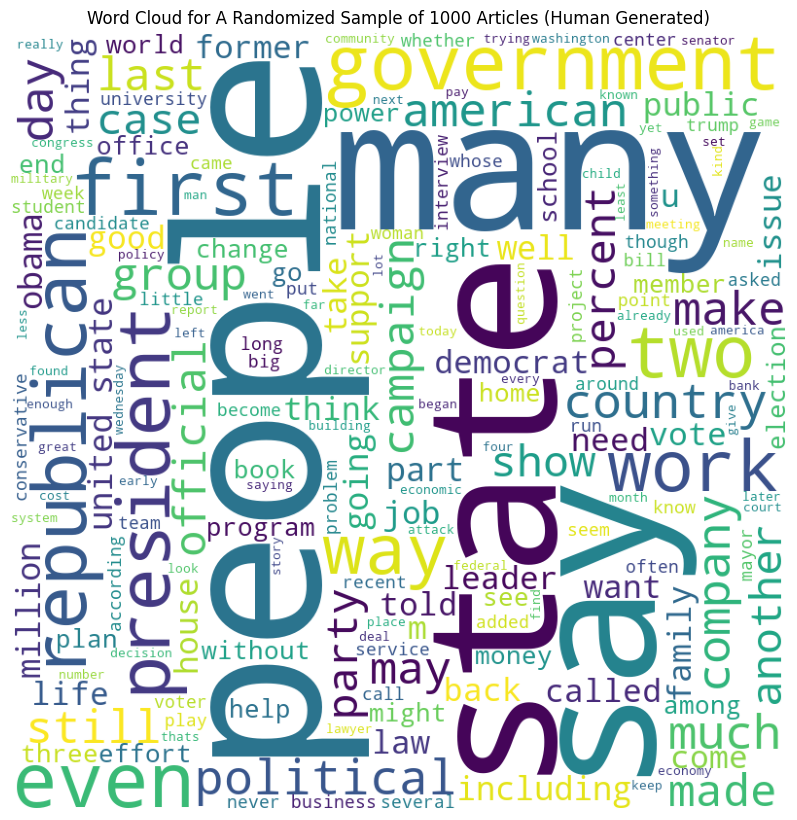

In [ ]:
processed_merged_df = pd.concat([real_processed_sample, fake_processed_sample])
processed_merged_df.reset_index(inplace = True, drop = True)
joint_1000text = " ".join(article for article in real_processed_sample["Cleaned_Article"].sample(1000, random_state= 2950))

stopwords = set(STOPWORDS)
# add additional filtering to provide more insightful information
stopwords.update(["said", "would", "time", "year", "one", "city", "like", "mr", "new", "york", "times"])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words= 200,
                min_font_size = 10).generate(joint_1000text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Word Cloud for A Randomized Sample of 1000 Articles (Human Generated)")
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

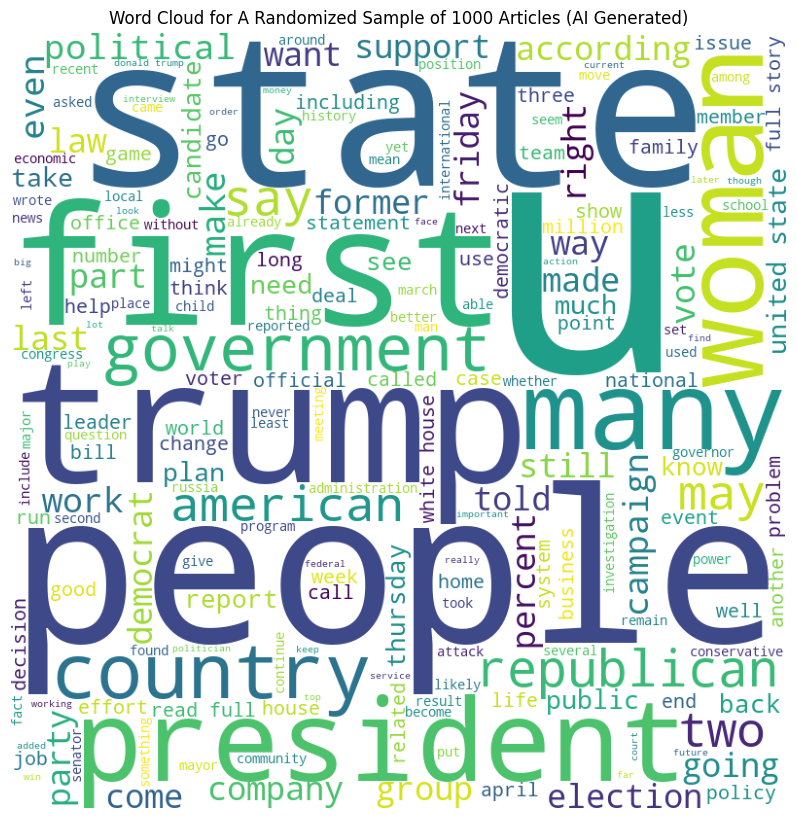

In [15]:
joint_1000text = " ".join(article for article in fake_processed_sample["Cleaned_Article"].sample(1000, random_state= 2950))

stopwords = set(STOPWORDS)
# add additional filtering to provide more insightful information
stopwords.update(["said", "would", "time", "year", "one", "city", "like", "mr", "new", "york", "times"])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words= 200,
                min_font_size = 10).generate(joint_1000text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Word Cloud for A Randomized Sample of 1000 Articles (AI Generated)")
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Word Frequency Analysis
Are there differences in human word choice and AI word choice? Are there any behavioral trends in term frequency?

In [16]:
# Create a bag of words for AI-Generated articles and non-AI generated articles
count_vectorizer = CountVectorizer()
count_vectorizer.fit(filtered_df["Cleaned_Article"])

CountVectorizer()

In [17]:
AI_bag_words = count_vectorizer.transform(fake_processed_sample["Cleaned_Article"])
real_bag_words = count_vectorizer.transform(real_processed_sample["Cleaned_Article"])
AI_word_counts = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(), 
                               'count': AI_bag_words.toarray().sum(axis=0)})
real_word_counts = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(),
                                'count': real_bag_words.toarray().sum(axis=0)})

In [18]:
AI_word_counts.sort_values(by='count', ascending=False, inplace=True)
AI_word_counts.head(20)

,word,count
86470,said,9211
67551,new,7616
110244,would,5543
95063,state,5293
100743,time,5123
65275,mr,5005
110921,year,4998
78013,president,4976
70842,one,4949
102633,trump,4677


In [19]:
real_word_counts.sort_values(by='count', ascending=False, inplace=True)
real_word_counts.head(20)

,word,count
65275,mr,24768
86470,said,23851
110244,would,8245
110921,year,7602
70842,one,7372
67551,new,6879
95063,state,6660
74275,people,5695
56562,like,5443
100743,time,5018


In [20]:
words_unique_AI = AI_word_counts[~AI_word_counts['word'].isin(real_word_counts['word'])]
print (f"The number of words that are used by the AI and not humans is {words_unique_AI.shape[0]}")
unique_real_words = real_word_counts[~real_word_counts['word'].isin(AI_word_counts['word'])]
print (f"The number of words that are used by the humans and not AI is {unique_real_words.shape[0]}")

The number of words that are used by the AI and not humans is 0
The number of words that are used by the humans and not AI is 0


From these two dataframes of most frequently used words and their respective word count, we can observe that the human use of honorifics (Mr) is approximately 380 times more than that of AI. However, outside of this, there seems to be many overlaps between common words. 

In addition, human-generated articles has higher word counts than AI-generated word count. On average, is article length insightful for differentiating between an AI-generated article and human generated article?

In [21]:
fake_unprocessed_sample["Word_Count"] = fake_unprocessed_sample["Article"].apply(lambda n: len(n.split()))
real_unprocessed_sample["Word_Count"] = real_unprocessed_sample["Article"].apply(lambda n: len(n.split()))
print(f"""On average, AI-Generated articles has approximately 
      {fake_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")

On average, AI-Generated articles has approximately 
      432.72 words per article.
On average, non AI-Generated articles has approximately 
      576.66 words per article.


In [22]:
fake_processed_sample["Word_Count"] = fake_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
real_processed_sample["Word_Count"] = real_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
print(f"""On average, AI-Generated articles has approximately 
      {fake_processed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_processed_sample['Word_Count'].mean():.2f} words per article.""")

On average, AI-Generated articles has approximately 
      226.25 words per article.
On average, non AI-Generated articles has approximately 
      323.61 words per article.


From above, we can discover that on average non AI-Generated articles has approximately 80 more words than AI-Generated articles.

Do the non AI-Generated articles contain more jargon and fluff? How can we use ngram analysis to analyze the particular context the the words in the dictionaries are used and the frequency in which phrases are used and repeated?

In [23]:
def get_ngram(article, num):
    """
    articles(string): A column of text to be used for n-gram analysis
    num (positive, non-zero integer): The amount of words per tuple used for 
    analysis
    num (positive integer): A positive, non-zero integer to indicate what the 
    desired value for n is to consider contiguous sequences of n words. 

    Returns a dataframe containing cumulative n-gram tuples, frequencies, and
    source (whether the n-gram tuples are from AI-generated sources or not).
    """
    tokens = article.split()
    ngram_token = list(ngrams(tokens, num))
    counts = Counter(ngram_token)
    return counts

def combine_ngram_frequencies(articles, num, fake):
    """
    articles(string): A column of text to be used for n-gram analysis
    num (positive, non-zero integer): The amount of words per tuple used for 
    analysis
    fake (1 or 0): Indicates if the column of articles inputted are fake 
    (AI-Generated) or not. Should be 1 if the articles are AI-Generated. Should
    be 0 if the articles are human composed.

    Returns a dataframe containing cumulative n-gram tuples, frequencies, and
    source (whether the n-gram tuples are from AI-generated sources or not).
    """
    assert isinstance(num, int)
    combined_counts = Counter()
    
    for article in articles:
        counts = get_ngram(article, num)
        combined_counts.update(counts)
    
    # Convert the combined counts to a DataFrame
    freq_df = pd.DataFrame(combined_counts.items(), columns=[f'{num}gram', 'frequency'])
    freq_df["fake"] = fake

    # Ensure the frequency column is of type int
    freq_df['frequency'] = freq_df['frequency'].astype(int)

    # Convert the n-gram tuples to strings for better readability
    freq_df[f'{num}gram'] = freq_df[f'{num}gram'].apply(lambda x: ' '.join(x))

    # Sort the DataFrame by frequency in descending order
    freq_df = freq_df.sort_values(by='frequency', ascending=False)
    freq_df.reset_index(inplace=True, drop=True)
    return freq_df

#### Preparation of dataset used for n-gram analysis.

Since we are looking to analyze patterns and general tone, using the unprocessed
text that has not been lemmatized would be best to produce substrings that can be
interpreted. 

For this analysis, we will be using 5-gram analysis with the focus on analyzing
transition 

In [24]:
unprocessed_fake_5gram = combine_ngram_frequencies(
    fake_unprocessed_sample["Article"], 5, 1
    )
unprocessed_real_5gram = combine_ngram_frequencies(real_unprocessed_sample["Article"], 5, 0)
merged_unprocessed = pd.concat([unprocessed_fake_5gram, unprocessed_real_5gram])
merged_unprocessed = merged_unprocessed.sort_values(by="frequency", ascending=False)
merged_unprocessed.reset_index(inplace=True, drop=True)
top75 = merged_unprocessed.head(75)
top75.head(11)

,5gram,frequency,fake
0,read the full story at,1094,1
1,the full story at the,749,1
2,the new york times. related,272,1
3,at the new york times.,269,1
4,story at the new york,268,1
5,full story at the new,267,1
6,full story at the washington,125,1
7,story at the washington post.,123,1
8,at the washington post. related,121,1
9,full story at the guardian.,100,1


In [25]:
top250 = merged_unprocessed.head(250)
top250_pivoted = top250.pivot(index='5gram', columns='fake', values='frequency').fillna(0)
top250_pivoted.columns = ["real", "AI"]
top250_pivoted.head()

,real,AI
5gram,,
"""at the end of the",15.0,0.0
"""there are a lot of",16.0,0.0
"340 west 50th street, clinton,",19.0,0.0
"44th street, (212) 239-6200, telecharge.com.",20.0,0.0
"45th street, (212) 239-6200, telecharge.com.",28.0,0.0


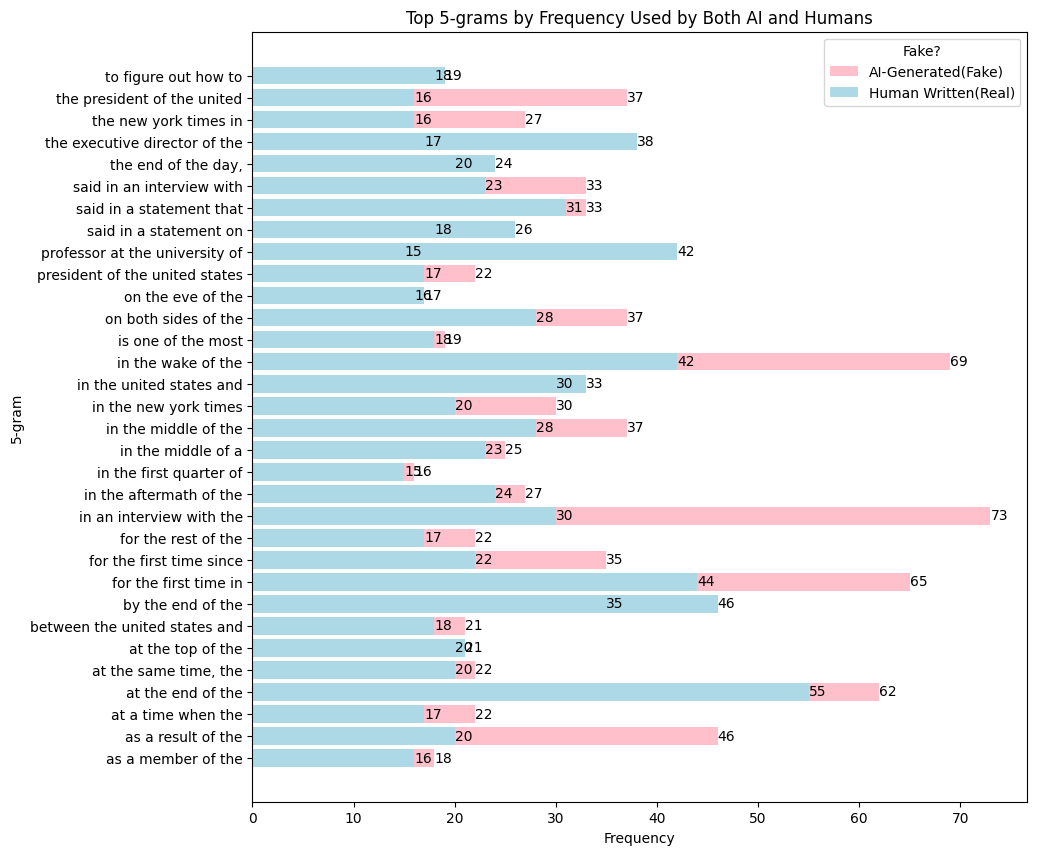

In [26]:
top250_overlap = top250_pivoted[(top250_pivoted["real"] != 0.0) & top250_pivoted["AI"] !=0]
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

bars_fake = ax.barh(top250_overlap.index, top250_overlap["AI"], color='pink', label='AI-Generated(Fake)')
bars_real = ax.barh(top250_overlap.index, top250_overlap["real"], color='lightblue', label='Human Written(Real)')

# Add labels to each bar
for bars in [bars_real, bars_fake]:
    ax.bar_label(bars, fmt='{:,.0f}')

# Set plot title and labels
plt.title("Top 5-grams by Frequency Used by Both AI and Humans")
plt.xlabel("Frequency")
plt.ylabel("5-gram")
plt.legend(title="Fake?")
#plt.tight_layout()

# Show the plot
plt.show()


In [27]:
top250_overlap = top250_pivoted[(top250_pivoted["real"] != 0.0) & (top250_pivoted["AI"] != 0)]
top250_overlap.tail(50)

,real,AI
5gram,,
as a member of the,16.0,18.0
as a result of the,20.0,46.0
at a time when the,17.0,22.0
at the end of the,55.0,62.0
"at the same time, the",20.0,22.0
at the top of the,21.0,20.0
between the united states and,18.0,21.0
by the end of the,46.0,35.0
for the first time in,44.0,65.0


In [28]:
fivegram_unique_AI = pd.DataFrame(unprocessed_fake_5gram[~unprocessed_fake_5gram['5gram'].isin(unprocessed_real_5gram['5gram'])])
print (f"The number of words that are used by the AI and not humans is {fivegram_unique_AI.shape[0]}")
fivegram_unique_real = pd.DataFrame(unprocessed_real_5gram[~unprocessed_real_5gram['5gram'].isin(unprocessed_fake_5gram['5gram'])])
print (f"The number of words that are used by the humans and not AI is {fivegram_unique_real.shape[0]}")

The number of words that are used by the AI and not humans is 2084652
The number of words that are used by the humans and not AI is 2795286


In [29]:
fivegram_unique_AI.sort_values(by="frequency", ascending=False, inplace=True)
fivegram_unique_AI.reset_index(inplace=True, drop=True)
fivegram_unique_AI.head(20)

,5gram,frequency,fake
0,read the full story at,1094,1
1,the full story at the,749,1
2,the new york times. related,272,1
3,story at the new york,268,1
4,full story at the new,267,1
5,full story at the washington,125,1
6,story at the washington post.,123,1
7,at the washington post. related,121,1
8,full story at the guardian.,100,1
9,story at the guardian. related,99,1


In [30]:
fivegram_unique_real.sort_values(by="frequency", ascending = False, inplace=True)
fivegram_unique_real.reset_index(inplace=True, drop=True)
fivegram_unique_real.head(20)

,5gram,frequency,fake
0,"street, clinton, (212) 239-6200, telecharge.com.",60,0
1,"west 45th street, (212) 239-6200,",29,0
2,"45th street, (212) 239-6200, telecharge.com.",28,0
3,vice president joseph r. biden,26,0
4,"west 42nd street, clinton, (212)",25,0
5,the rev. dr. martin luther,22,0
6,"west 44th street, (212) 239-6200,",22,0
7,"new world stages, 340 west",20,0
8,"street, (212) 239-6200, telecharge.com. (brant...",20,0
9,"world stages, 340 west 50th",20,0


In [31]:
# top65 = pd.DataFrame(top75.iloc[11:,:])
# top65.reset_index(inplace=True, drop=True)
# top65
# plt.figure(figsize=(10, 8))

# gram_freq_plot = sns.barplot(
#     data=top65,
#     x="frequency",
#     y="5gram",
#     hue="fake",
#     dodge=False
# )

# for container in gram_freq_plot.containers:
#     gram_freq_plot.bar_label(container, fmt='{:,.0f}')

# plt.title("Top 5-grams by Frequency (Human Written(Real) vs. AI-Generated(Fake) Articles)")
# plt.xlabel("Frequency")
# plt.ylabel("5-gram")
# plt.legend(title="Fake?")
# plt.tight_layout()
# plt.show()

In [32]:
# pivot_df_top65 = top65.pivot(index='5gram', columns='fake', values='frequency').fillna(0)
# pivot_df_top65.columns = ["real", "AI"]
# pivot_df_top65.sort_values(by = "AI", ascending= False, inplace=True)
# pivot_df_top65.head()

# pivot_df_top65[(pivot_df_top65["real"] != 0.0) & pivot_df_top65["AI"] !=0]
# pivot_df_top65[pivot_df_top65["real"] == 0.0]
# pivot_df_top65[pivot_df_top65["AI"] == 0.0]

In [33]:
# # Create the figure and axis
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the bars for 'real' articles
# bars_real = ax.barh(pivot_df_top65.index, pivot_df_top65["real"], color='lightblue', label='Human')

# # Plot the bars for 'fake' articles on top of the 'real' bars
# bars_fake = ax.barh(pivot_df_top65.index, pivot_df_top65["AI"], left=pivot_df_top65["real"], color='pink', label='AI')

# # Add labels to each bar
# for bars in [bars_real, bars_fake]:
#     ax.bar_label(bars, fmt='{:,.0f}')

# # Set plot title and labels
# plt.title("Top 5-grams by Frequency (Human Written(Real) vs. AI-Generated(Fake) Articles)")
# plt.xlabel("Frequency")
# plt.ylabel("5-gram")
# plt.legend(title="Fake?")
# #plt.tight_layout()

# # Show the plot
# plt.show()


In [34]:
# def get_ngram(article, num):
#     tokens = article.split()
#     ngram_token = list(ngrams(tokens, num))
#     return ngram_token

# def get_ngram2(article, num):
#     assert isinstance(num, int)
#     tokens = article.split()

#     ngram_token = list(ngrams(tokens, num))

#     counts = Counter(ngram_token)
#     freq_df = pd.DataFrame(counts.items(), columns=[f'{num}gram', 'frequency'])

#     freq_df['frequency'] = freq_df['frequency'].astype(int)
#     freq_df[f'{num}gram'] = freq_df[f'{num}gram'].astype(str)
#     freq_df = freq_df.sort_values(by='frequency', ascending=False)
#     freq_df.reset_index(inplace=True, drop = True)
#     print (freq_df.head(20))
#     print (freq_df.shape)
#     return freq_df

In [35]:
# top30_fake = pd.DataFrame(f_trigram_df.iloc[:30,])
# top30_fake["source"] = "fake"
# top30_real = pd.DataFrame(r_trigram_df.iloc[:30,])
# top30_real["source"] = "real"
# merged_top30 = pd.concat([top30_real, top30_fake])
# merged_top30 = merged_top30.sort_values(by="frequency", ascending=False)
# merged_top30.head()

In [36]:
# ftest_df["5gram"] = ftest_df["Cleaned_Article"].apply(lambda x: get_ngram(x, 5))
# f_all_trigrams = sum(ftest_df['5gram'], [])
# f_trigram_counts = Counter(f_all_trigrams)
# f_trigram_df = pd.DataFrame(f_trigram_counts.items(), columns=['5gram', 'frequency'])
# f_trigram_df['frequency'] = f_trigram_df['frequency'].astype(int)
# f_trigram_df = f_trigram_df.sort_values(by='frequency', ascending=False)
# f_trigram_df.reset_index(inplace=True, drop = True)
# f_trigram_df['5gram'] = f_trigram_df['5gram'].astype("string")
# f_trigram_df.head()
# rtest_df["5gram"] = rtest_df["Cleaned_Article"].apply(lambda x: get_ngram(x, 5))
# r_all_trigrams = sum(rtest_df['5gram'], [])
# r_trigram_counts = Counter(r_all_trigrams)
# r_trigram_df = pd.DataFrame(r_trigram_counts.items(), columns=['5gram', 'frequency'])
# r_trigram_df['frequency'] = r_trigram_df['frequency'].astype(int)
# r_trigram_df = r_trigram_df.sort_values(by='frequency', ascending=False)
# r_trigram_df.reset_index(inplace=True, drop = True)
# r_trigram_df['5gram'] = r_trigram_df['5gram'].astype("string")
# r_trigram_df.head()

In [37]:
# def extract_ngrams(data, n):
#     n_grams = ngrams(nltk.word_tokenize(data), n)
#     n_counter = Counter(n_grams)
#     freq = pd.DataFrame(n_counter.items(), columns=["Words", "Frequency"]).sort_values(by = "Frequency")
#     return freq

# ai_two_gram = pd.concat(ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2)))
# accumulated_ngrams = ai_two_gram.groupby("Words", as_index=False).sum()
# accumulated_ngrams.head()

# accumulated_ngrams.shape

<!-- ai_two_gram['Words'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2))
ai_two_gram['Frequency'] = Counter()
ai_three_gram['3_gram'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 3))
ai_articles['4_gram'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 4))

two_gram['2_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2))
real_articles['3_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 3))
real_articles['4_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 4)) -->

### KMeans Clustering with Inverse Document Frequency (IDF)Normalization 
References Used: https://scikit-learn.org/1.5/auto_examples/text/plot_document_clustering.html

In [38]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, stop_words="english")
X_tfidf = vectorizer.fit_transform(processed_merged_df["Cleaned_Article"])

In [39]:
# True labels for evaluation
labels = processed_merged_df["Fake"].tolist()
evaluations = []
evaluations_std = []

# Define the evaluation function
def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name
    scores = defaultdict(list)
    
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        km.fit(X)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000))
    
    evaluation = {"estimator": name}
    evaluation_std = {"estimator": name}
    
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


In the function above, five scores commonly used to evaluate clustering algorithms are used. 

**Homogeneity**: Measures if each cluster contains only members of a single class. A low score (close to 0) indicates that the clusters are not homogeneous, meaning that the clusters contain a mix of different classes.

**Completeness**: Measures if all members of a given class are assigned to the same cluster. A low score (close to 0) suggests that the members of each class are spread across multiple clusters, indicating poor clustering performance.

**V-measure**: The harmonic mean of homogeneity and completeness. A low V-measure indicates that both homogeneity and completeness are low, reflecting poor overall clustering quality.

**Adjusted Rand-Index**: Measures the similarity between the true labels and the clustering labels, adjusted for chance. A low score (close to 0) indicates that the clustering results are not much better than random assignment.

**Silhouette Coefficient**: Measures how similar an object is to its own cluster compared to other clusters. A low score (close to 0) suggests that the clusters are not well-separated, and the data points are not well-clustered.

In [40]:
kmeans = KMeans(n_clusters=2)
fit_and_evaluate(kmeans, X_tfidf, labels=labels, name="KMeans on tf-idf vectors")

Homogeneity: 0.024 ± 0.009
Completeness: 0.030 ± 0.013
V-measure: 0.027 ± 0.011
Adjusted Rand-Index: 0.024 ± 0.008
Silhouette Coefficient: 0.003 ± 0.000


As shown above, when it's set to two clusters and initialized using the greedy kmeans++ and the distribution of the points, it does not perform well. The purity of resulting clusters are low and the algorthm is not accurately clustering the article. To address this, possible steps could be to tune the parameters and use principal component analysis to reduce the amount of dimensions.

First, I will experiment with the initialization of the centriods and setting it to random, where the inital centroids will be randomly selected. 

In [41]:
kmeans = KMeans(n_clusters=2, init = "random")
fit_and_evaluate(kmeans, X_tfidf, labels=labels, name="KMeans on tf-idf vectors")

Homogeneity: 0.034 ± 0.006
Completeness: 0.044 ± 0.009
V-measure: 0.038 ± 0.008
Adjusted Rand-Index: 0.033 ± 0.005
Silhouette Coefficient: 0.003 ± 0.000


From the above values, we can see that randomly initializing the centroid did help with increasing the evaluation metrics. Using the random centriod initialization method, how would the changing the number of independent runs change this? 
When using a random centriod initialization method, the algorithm runs 10 times and the best output is returned. 
Would increasing the amount of times the algorithm is run enhance the performance?

include code here for graph where x is value for n_init and y is the graphs with the above scores

perhaps add article length as another covariate

In [42]:
kmeans = KMeans(n_clusters=2, max_iter=100, n_init="auto")
fit_and_evaluate(kmeans, X_tfidf, labels=labels, name="KMeans on tf-idf vectors")

Homogeneity: 0.024 ± 0.009
Completeness: 0.030 ± 0.013
V-measure: 0.027 ± 0.011
Adjusted Rand-Index: 0.024 ± 0.008
Silhouette Coefficient: 0.003 ± 0.000


From the data exploration section, we see that there is an difference between article length and the source of the article (human generated or AI generated). Is this difference significant?

In [43]:
processed_merged_df["Article_Length"] = processed_merged_df["Cleaned_Article"].apply(lambda n: len(n.split()))
#processed_wordlength_df = pd.concat([pd.DataFrame(X_tfidf.toarray(),])

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(processed_merged_df["Article_Length"], 
                                                processed_merged_df["Fake"], 
                                                test_size=0.3, 
                                                random_state=2950)



,Fake,Article,Cleaned_Article,Article_Length
9961,0,"another local resident, the owner of a small g...",another local resident owner small gift shop c...,314
10480,0,"for borrowing $105 million in 2011, taxpayers ...",borrowing million taxpayer perhaps would accur...,399
14790,0,"michael r. bloomberg, the former mayor of new ...",michael r bloomberg former mayor new york city...,105
15419,0,mr. blesa has denied wrongdoing and has not be...,mr blesa denied wrongdoing formally charged cr...,362
14495,0,"""they are afraid of the results, that the coun...",afraid result country cant take said adding fe...,378
13917,0,"for congressional republicans, mr. trump's inf...",congressional republican mr trump inflammatory...,173
9370,0,the two kinds of gaps appear to have slightly ...,two kind gap appear slightly different explana...,234
10221,0,they used that nomenclature because of what th...,used nomenclature found next explored relation...,149
15153,0,"these are all good efforts, but a patchwork so...",good effort patchwork solution enough anyone c...,160
16247,0,what purpose are election-night speeches meant...,purpose electionnight speech meant serve addre...,297


In [44]:
# fake_tfidf = tfidf_vectorizer.fit_transform(filtered_df["Cleaned_Article"])
# tfidf_vocabulary = tfidf_vectorizer.get_feature_names_out()
# count_vocabulary = count_vectorizer.get_feature_names_out(word_counts)
# size_tfidf = tfidf_vocabulary.shape[0]
# size_vocab = count_vocabulary.shape[0]
# size_compare = np.round(size_tfidf / size_vocab, 2)
# print ("Size of tfidf vocabulary is " + str(size_compare) +
#       " of the overall vocabulary.")
# print (tfidf_vocabulary)

### Principal Component Analysis Dimension Reduction
Using the vectorized text our data from the section, above, we want to apply PCA to reduce the dimension of our model to reduce variability from large dimension.
can't evaluate text as a factor
appoarch for text:
- labeled -> what are the most similar nouns? let's look at the actually words with fake (word cloud) 
- run cluster using LDA and see what default  (run together and separately and see topic differences)
- extended: grammar and personal (read about it and put into project)
- so much text -> maybe need to isolate specific words -> but may not be helpful  -> ask for example from Amish
- try to running with a smaller sample

In [45]:
#pca = PCA()
#pca.fit(X_tfidf)
#pca.explained_variance_ratio_

### LDA Analysis
https://developer.ibm.com/tutorials/awb-lda-topic-modeling-text-analysis-python/

In [46]:
from gensim import matutils
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models as gensimvisualize
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from pprint import pprint

In [47]:
corpus = matutils.Sparse2Corpus(X_tfidf, documents_columns=False)
id2word = corpora.Dictionary(processed_merged_df["Cleaned_Article"].apply(lambda x: x.split()))

In [48]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=2)

# View the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.003*"bragens" + 0.002*"lag" + 0.001*"literati" + 0.001*"rudolphs" + '
  '0.001*"knipper" + 0.001*"primorsky" + 0.001*"qadri" + 0.001*"upstream" + '
  '0.001*"wooden" + 0.001*"sothebys"'),
 (1,
  '0.002*"bragens" + 0.002*"lag" + 0.001*"knipper" + 0.001*"literati" + '
  '0.001*"rudolphs" + 0.001*"upstream" + 0.001*"qadri" + 0.001*"primorsky" + '
  '0.001*"sothebys" + 0.001*"wentz"')]


In [49]:
# lda = LatentDirichletAllocation(n_components=2, random_state=2950)
# lda.fit(X_tfidf)
# X_topics = lda.transform(X_tfidf)
# terms = vectorizer.get_feature_names_out()
# for idx, topic in enumerate(lda.components_):
#     print(f"Topic {idx}:")
#     print(" ".join([terms[i] for i in topic.argsort()[-10:]]))

In [50]:
feature_names = vectorizer.get_feature_names_out()
word_frequencies = np.asarray(X_tfidf.sum(axis=0)).flatten()
id2word = corpora.Dictionary([feature_names])
id2word.filter_extremes(no_below=5, no_above=0.9)

In [51]:
frequency_dict = dict(zip(feature_names, word_frequencies))
frequency_dict

{'aa': 0.5288244974970254,
 'aaa': 0.4382703859819984,
 'aaron': 5.175535120029846,
 'aarp': 0.6555307793857318,
 'ab': 1.1329484708739428,
 'aback': 1.1843005367465445,
 'abadi': 1.1428575163735546,
 'abandon': 4.827746758846927,
 'abandoned': 8.617392258436915,
 'abandoning': 2.4956780978145243,
 'abandonment': 1.1725207337255938,
 'abatement': 0.9988842137304095,
 'abating': 0.3629309420616219,
 'abba': 0.28114211007528983,
 'abbas': 3.255934863577706,
 'abbey': 0.9236913499629048,
 'abbott': 5.062615940882484,
 'abbotts': 0.9390014154241652,
 'abbreviation': 0.41355314779328434,
 'abby': 1.345573897112879,
 'abc': 10.743107622547384,
 'abdel': 3.3509906095375372,
 'abdelaziz': 0.49191780014019915,
 'abdication': 0.5382580206947803,
 'abdomen': 0.34079893862616617,
 'abdu': 0.37078555836085664,
 'abducted': 1.9338127273983534,
 'abduction': 0.5134623797881969,
 'abdul': 3.599128740144682,
 'abdullah': 5.71386400552934,
 'abdullahs': 0.4552241471238756,
 'abe': 7.51363367228416,
 'ab

In [52]:
#https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
# lda_model = LatentDirichletAllocation(n_components=20, max_iter=10, 
#                                       learning_method='online', random_state=100, 
#                                       batch_size=128, evaluate_every = -1, 
#                                       n_jobs = -1)
# lda_output = lda_model.fit_transform(X_tfidf)
# print(lda_model)  # Model attributes

### Classification of article party alignment

In [53]:
# installs used 
# pip install transformers
# pip install ipywidgets
# pip3 install torch torchvision torchaudio (may vary based on device)
# pip install tensorflow
# pip install tf_keras
# Load model directly
# from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline

# pipe = pipeline("text-classification", model="launch/POLITICS")
# news_sample = news_df.sample(n = 10)
# def classify_party(article):
#     result = pipe(article)[0]
#     return (pd.Series([result['label'], result['score']]))
# def find_leng(article):
#     return (len(article.split()) < 500)
# short_articles = news_sample[news_sample["Cleaned_Article"].apply(find_leng)]
# short_articles
#short_articles.shape
#for article in short_articles["Cleaned_Article"]:
    #if (len(article.split()) >= 512):
        # print (len(article.split()))
#short_articles[['label', 'confidence']] = short_articles['Cleaned_Article'].apply(classify_party)
#tokenizer = AutoTokenizer.from_pretrained("launch/POLITICS")
#model = AutoModelForMaskedLM.from_pretrained("launch/POLITICS")
#encoded = short_articles['Cleaned_Article'].apply(tokenizer, return_tensors="pt")
# text = short_articles['Cleaned_Article'].iloc[1]
# tokenizer(text, return_tensors="pt")

how to detact if it's AI?
- missing out on the functionality of the AI part (deterministic)
- clustering (defining the features: liklihoold of words in AI or non-AI, neural network (every possible word combo))
- classification, clustering with NLP, neural networks (with words)

## Word Frequency Analysis